**Modelling of Physical Systems lab: on numerical solutions of transport PDEs**   
AGH, April 16, Sylwester Arabas (sylwester.arabas@agh.edu.pl)


**Plan for today**:   
1. advection PDE   
2. overview of applications   
3. simple numerical solution using the "upwind" scheme ("toy" implementation in Python)   
4. robust numerical solution using the "MPDATA" scheme ("toy" implementation in Python)   
5. **homework**: convergence analysis for upwind vs. MPDATA (e.g., plot log(error) vs. log(dx))   
6. PyMPDATA: open Pythonic & high-performance implementation of MPDATA developed @AGH

(**Eng./MSc. topics available!**)   

**1. advection PDE**

Let's introduce a few symbols:   
* ${\color{red}t}$: time   
* ${\color{blue}x}$: physical coordinate (e.g., distance or altitude)   
* ${\color{green}\psi}({\color{blue}x})$: scalar field (e.g., pollutant concentration)   
* ${\color{brown}u}$: carrier velocity field (e.g., wind)   

Transport of $\color{green}\psi$ due to advection by $\color{brown}u$ can be modelled with the advection equation:
$$ \partial_{\color{red} t} {\color{green}\psi} + \partial_{\color{blue}x} \left({\color{brown}u} {\color{green}\psi}\right) = 0 $$

For the special case of $\partial_{\color{blue}x} {\color{brown}u}=0$, an analytical solution describing translation of the signal is readily available:
$$ {\color{green}\psi}({\color{blue}x}, {\color{red}t})=\psi_0({\color{blue}x} - {\color{brown}u}{\color{red}t})$$
where $\psi_0({\color{blue}x})={\color{green}\psi}({\color{blue}x}, 0)$. 

Let's depict the problem using NumPy and matplotlib:

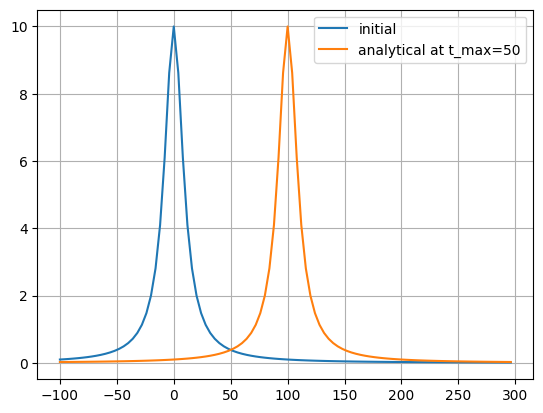

In [1]:
import numpy as np
from matplotlib import pyplot

def psi_0(x):
    """ https://en.wikipedia.org/wiki/Witch_of_Agnesi """
    a = 5
    return 8*a**3 / (x**2 + 4*a**2)

nx = 100
x, dx = np.linspace(-100, 300, nx, endpoint=False, retstep=True)
u = 2
t_max = 50

pyplot.plot(x, psi_0(x), label='initial')
pyplot.plot(x, psi_0(x - u * t_max), label=f'analytical at {t_max=}')
pyplot.legend()
pyplot.grid()

**2. overview of applications**

* **computational fluid dynamics**: Navier-Stokes momentum equation ($\psi$: fluid velocity)
* **fluid thermodynamics**: energy conservation ($\psi$: thermal energy)
* **atmospheric modelling incl. weather prediction**: mass conservation ($\psi$: humidity, rain, pollutants, ...)
* **derivative pricing in financial mathematics**: Black-Scholes equation ($\psi$: discounted value of a derivative instrument)
* ...

**3. simple numerical solution using the "upwind" scheme coded in Python**

For cases where the velocity varies in space (and for many other more complex cases), numerical integration is the only way of solving the advection PDE. Among numerous numerical schemes for solving it, let's look at the basic **upwind** solver: 

Let's consider the following discretisation of the problem:   
* ${\color{red}n} = \frac{\color{red}t}{\Delta t} \in 0, 1, \ldots$   
* ${\color{blue}i} = \frac{\color{blue}x}{\Delta x} \in 0, 1, \ldots$   
* ${\color{brown}C} = {\color{brown}u}\frac{\Delta t}{\Delta x}$ (so called Courant number)   
* ${\color{green}\psi}_{\color{blue}i}^{\color{red}n}$: scalar field at "grid cell" $\color{blue}i$ in space at time "level" ${\color{red}n}$   

The explicit (forward-in-time) upwind scheme is defined as:
$$
  {\color{green}\psi}^{{\color{red}n}+1}_{\color{blue}i} = {\color{green}\psi}^{\color{red}n}_{\color{blue}i} - \left[\frac{{\color{brown}C} + |{\color{brown}C}|}{2}\left({\color{green}\psi}^{\color{red}n}_{\color{blue}i} - {\color{green}\psi}^{\color{red}n}_{{\color{blue}i}-1}\right)+\frac{{\color{brown}C}-|{\color{brown}C}|}{2}\left({\color{green}\psi}^{\color{red}n}_{{\color{blue}i}+1}-{\color{green}\psi}^{\color{red}n}_{\color{blue}i}\right)\right]
$$

In [2]:
# algorithm coded in Python/NumPy:

def flux(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

class shift:
    def __radd__(self, i): 
        return slice(i.start+1, i.stop+1)
    def __rsub__(self, i): 
        return slice(i.start-1, i.stop-1)

def upwind(psi, i, C):
    return psi[i] - flux(psi[i    ], psi[i+one], C[i]) + \
                    flux(psi[i-one], psi[i    ], C[i-one]) 

In [3]:
# counterparts of mathematical symbols:

i = slice(1,nx-2)
one = shift()

nt = 50
dt = t_max / nt

C = u * dt / dx
C_phys = np.full(nx-1, C)

In [4]:
# numerical integration using "upwind":
psi_upwind = psi_0(x)
for _ in range(nt):
    psi_upwind[i] = upwind(psi_upwind, i, C_phys)

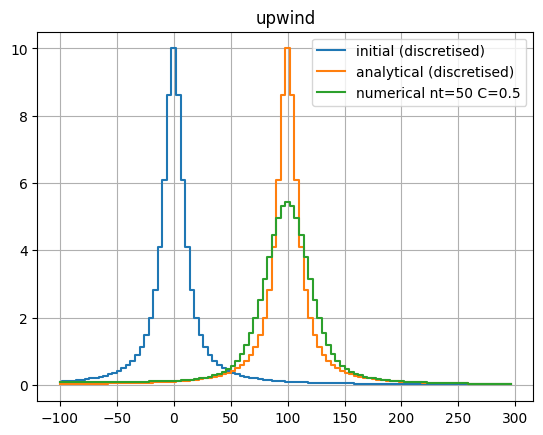

In [5]:
def plot(psi, title):
    pyplot.step(x, psi_0(x), label='initial (discretised)', where='mid')
    pyplot.step(x, psi_0(x-u*t_max), label='analytical (discretised)', where='mid')
    pyplot.step(x, psi, label=f'numerical {nt=} {C=}', where='mid')
    pyplot.legend()
    pyplot.title(title)
    pyplot.grid()
plot(psi_upwind, "upwind")

**4. robust numerical solution using the "MPDATA" scheme (coded in Python)**

A robust iterative algorithm proposed in [Smolarkiewicz 1983 (Mon. Wea. Rev. 111)](https://doi.org/10.1175/1520-0493(1983)111%3C0479:ASPDAS%3E2.0.CO;2) to alleviate the "numerical diffusion" maintaining simplicity, conservativeness and stability characteristics of upwind:

- **first iteration**: ordinary upwind
- **next iterations**: upwind with physical Courant field $\color{brown}C$ replaced with an "antidiffusive" corrective ${\color{magenta}C'}$ 

$$ {\color{magenta}C'}_{j+\frac{1}{2}} = (|{\color{brown}C}_{j+\frac{1}{2}}| - {\color{brown}C}_{j+\frac{1}{2}}^2)  \frac{{\color{green}\psi}_{j+1} - {\color{green}\psi}_{j}}{{\color{green}\psi}_{j+1} + {\color{green}\psi}_j}$$

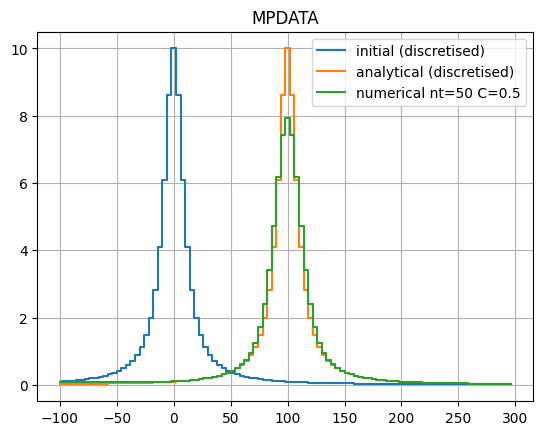

In [6]:
def C_corr(C, nx, psi):
    j = slice(0, nx-1)
    return (abs(C[j]) - C[j]**2) * (psi[j+one] - psi[j]) / (psi[j+one] + psi[j])

psi_mpdata = psi_0(x)
for _ in range(nt):
    psi_mpdata[i] = upwind(psi_mpdata, i, C_phys)
    psi_mpdata[i] = upwind(psi_mpdata, i, C_corr(C_phys, nx, psi_mpdata))
    
plot(psi_mpdata, "MPDATA")

**5. homework: convergence analysis for upwind vs. MPDATA (e.g., plot log(error) vs. log(dx))**   

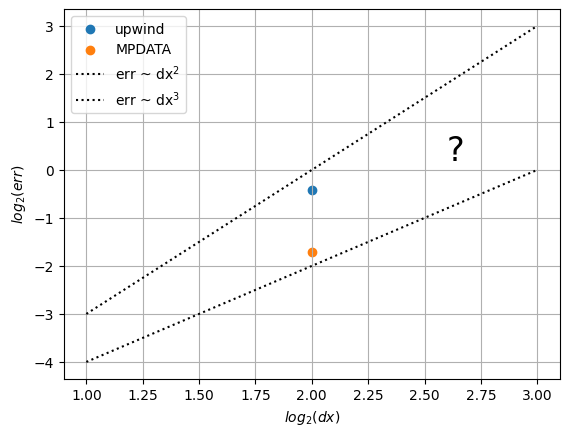

In [7]:
psi_analytic = psi_0(x - u * t_max)

def rmse(expected, actual):
    return np.sqrt(np.mean(np.square(expected - actual)))

pyplot.scatter([np.log2(dx)], [np.log2(rmse(psi_analytic, psi_upwind))], label='upwind')
pyplot.scatter([np.log2(dx)], [np.log2(rmse(psi_analytic, psi_mpdata))], label='MPDATA')

ln2dxs = np.asarray([1,2,3])  # TODO!
for k in (2, 3):
    pyplot.plot(ln2dxs, k * ln2dxs - 6, label=f'err ~ dx$^{k}$', color='black', linestyle=':')

pyplot.legend()
pyplot.xlabel('$log_2(dx)$')
pyplot.ylabel('$log_2(err)$')
pyplot.annotate("?", (2.6, .2), size=24)  # TODO!
pyplot.grid()

**6. PyMPDATA: open Pythonic & high-performance implementation of MPDATA developed @AGH**   
* https://github.com/open-atmos/PyMPDATA   
* https://github.com/open-atmos/PyMPDATA-MPI   

Eng. and MSc. projects available!   
* https://apd.usos.agh.edu.pl/my-apd/topics/show/12756   
* https://apd.usos.agh.edu.pl/my-apd/topics/show/12755   
* https://apd.usos.agh.edu.pl/my-apd/topics/show/12754   
* https://apd.usos.agh.edu.pl/my-apd/topics/show/10982   